## FREQUENZE

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   timestamp          379 non-null    object
 1   elapsed_time_ms    379 non-null    int64 
 2   effective_time_ms  379 non-null    int64 
 3   className          379 non-null    object
 4   accuracy           379 non-null    object
 5   recording_state    379 non-null    object
dtypes: int64(2), object(4)
memory usage: 17.9+ KB
None

Prime righe del dataset:
             timestamp  elapsed_time_ms  effective_time_ms     className  \
0  2024_12_20_12_51_57                9                  9  Bicipiti TRX   
1  2024_12_20_12_51_57               41                 41  Bicipiti TRX   
2  2024_12_20_12_51_57               91                 91  Bicipiti TRX   
3  2024_12_20_12_51_57              142                142  Bicipiti TRX   
4  2024_12_20_12_51_57          

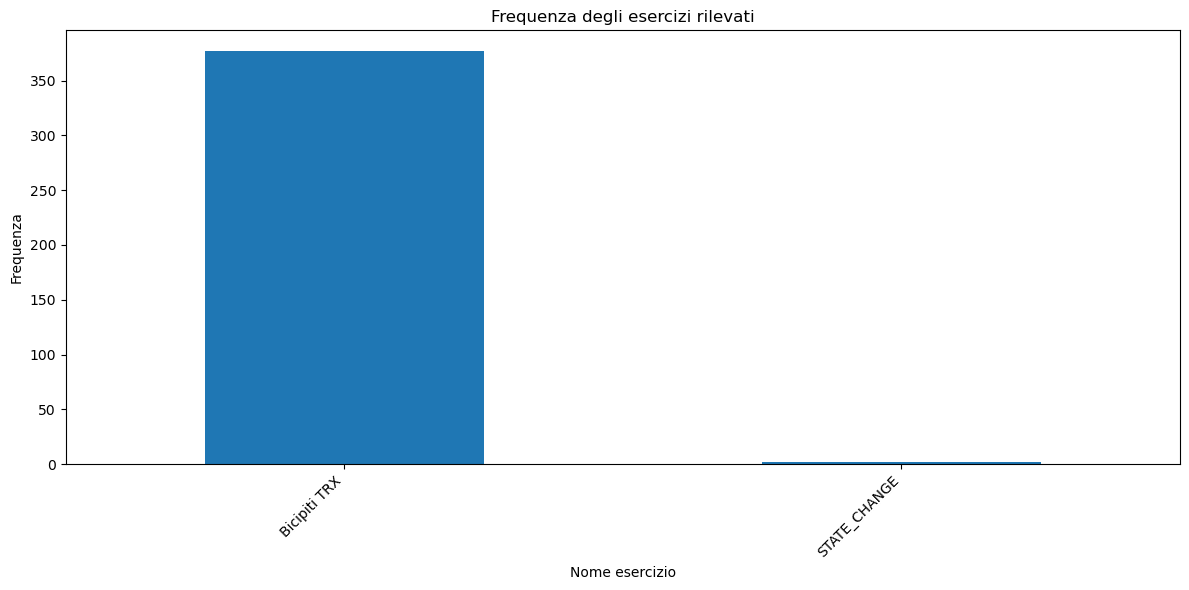


Risultati dell'analisi:

Durata totale complessiva di movimento: 19.00 secondi

Durata totale per ogni esercizio:
- Bicipiti TRX: 18.00 secondi
- STATE_CHANGE: 1.00 secondi

Ripetizioni stimate con 2 secondi per ripetizione:
- Bicipiti TRX: 9.00 ripetizioni
- STATE_CHANGE: 0.50 ripetizioni

Ripetizioni stimate con 3 secondi per ripetizione:
- Bicipiti TRX: 6.00 ripetizioni
- STATE_CHANGE: 0.33 ripetizioni

Analisi degli esercizi frequenti e vicini temporalmente:

Risultati dell'analisi:

Durata totale per ogni esercizio:
- Bicipiti TRX: 18.00 secondi

Ripetizioni stimate con 2 secondi per ripetizione:
- Bicipiti TRX: 9.00 ripetizioni

Ripetizioni stimate con 3 secondi per ripetizione:
- Bicipiti TRX: 6.00 ripetizioni


In [5]:
# Cella 1 - Importazioni e configurazione
import pandas as pd
import matplotlib.pyplot as plt
import os

# Percorso del file
file_path = 'predictions_2024_12_20_12_51_57.csv'

# Cella 2 - Definizione delle funzioni di supporto
def load_and_inspect_data(file_path):
    """Carica il dataset e mostra le informazioni di base."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Il file {file_path} non esiste.")

    data = pd.read_csv(file_path)
    print("Informazioni sul dataset:")
    print(data.info())
    print("\nPrime righe del dataset:")
    print(data.head())
    return data

def plot_exercise_frequency(data):
    """Crea un grafico della frequenza degli esercizi."""
    exercise_counts = data['className'].value_counts()
    plt.figure(figsize=(12, 6))
    exercise_counts.plot(kind='bar')
    plt.title('Frequenza degli esercizi rilevati')
    plt.xlabel('Nome esercizio')
    plt.ylabel('Frequenza')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def parse_custom_timestamp(timestamp_str):
    """Converte il timestamp dal formato personalizzato in datetime."""
    if isinstance(timestamp_str, pd.Timestamp):
        return timestamp_str
    parts = timestamp_str.split('_')
    return pd.Timestamp(
        year=int(parts[0]),
        month=int(parts[1]),
        day=int(parts[2]),
        hour=int(parts[3]),
        minute=int(parts[4]),
        second=int(parts[5])
    )

def preprocess_data(data):
    """Preprocessa i dati convertendo il timestamp una sola volta."""
    data = data.copy()
    data['timestamp'] = data['timestamp'].apply(parse_custom_timestamp)
    return data

def calculate_total_duration(data):
    """Calcola la durata totale per ogni esercizio basandosi sui timestamp."""
    data = preprocess_data(data)
    durations = {}
    total_movement_duration = 0
    for exercise_name in data['className'].unique():
        exercise_data = data[data['className'] == exercise_name]
        total_duration = (
            exercise_data['timestamp'].max() - exercise_data['timestamp'].min()
        ).total_seconds()
        durations[exercise_name] = total_duration
        total_movement_duration += total_duration
    return durations, total_movement_duration

def detect_frequent_and_close_exercises(data, time_threshold=2, frequency_threshold=20, min_duration=15):
    """Identifica gli esercizi più frequenti, vicini temporalmente e con durata significativa."""
    data = preprocess_data(data)
    frequent_close_exercises = {}
    grouped = data.groupby('className')
    for exercise, group in grouped:
        group = group.sort_values(by='timestamp')
        time_diffs = group['timestamp'].diff().dt.total_seconds().fillna(0)
        close_segments = (time_diffs <= time_threshold).sum()
        total_duration = (group['timestamp'].max() - group['timestamp'].min()).total_seconds()
        if len(group) >= frequency_threshold and close_segments > 0.95 * len(group) and total_duration >= min_duration:
            frequent_close_exercises[exercise] = total_duration
    return frequent_close_exercises

def estimate_repetitions(durations, rep_duration=2):
    """Stima il numero di ripetizioni per ogni esercizio basandosi sulla durata media di una ripetizione."""
    repetitions = {}
    for exercise_name, total_duration in durations.items():
        reps = total_duration / rep_duration
        repetitions[exercise_name] = reps
    return repetitions

def print_analysis_results(durations, total_movement_duration=None, reps_2s=None, reps_3s=None):
    """Stampa i risultati in modo leggibile."""
    print("\nRisultati dell'analisi:\n")
    if total_movement_duration is not None:
        print(f"Durata totale complessiva di movimento: {total_movement_duration:.2f} secondi\n")

    print("Durata totale per ogni esercizio:")
    for exercise_name, duration in sorted(durations.items()):
        print(f"- {exercise_name}: {duration:.2f} secondi")

    if reps_2s is not None:
        print("\nRipetizioni stimate con 2 secondi per ripetizione:")
        for exercise_name, reps in sorted(reps_2s.items()):
            print(f"- {exercise_name}: {reps:.2f} ripetizioni")

    if reps_3s is not None:
        print("\nRipetizioni stimate con 3 secondi per ripetizione:")
        for exercise_name, reps in sorted(reps_3s.items()):
            print(f"- {exercise_name}: {reps:.2f} ripetizioni")

# Cella 3 - Esecuzione dell'analisi
# Caricare e ispezionare i dati
try:
    data = load_and_inspect_data(file_path)
except FileNotFoundError as e:
    print(e)
    raise e

# Cella 4 - Analisi della frequenza degli esercizi
plot_exercise_frequency(data)

# Cella 5 - Calcolo delle durate e delle ripetizioni
# Calcolo della durata totale per ogni esercizio e del movimento complessivo
durations, total_movement_duration = calculate_total_duration(data)

# Stima delle ripetizioni per ogni esercizio
reps_2s = estimate_repetitions(durations, rep_duration=2)
reps_3s = estimate_repetitions(durations, rep_duration=3)

# Stampa i risultati
print_analysis_results(durations, total_movement_duration, reps_2s, reps_3s)

# Cella 6 - Analisi degli esercizi frequenti
# Identificazione degli esercizi più frequenti, vicini temporalmente e con durata significativa
frequent_close_exercises = detect_frequent_and_close_exercises(
    data, time_threshold=2, frequency_threshold=20, min_duration=15
)

# Stima delle ripetizioni per ogni esercizio frequente e vicino temporalmente
reps_2s_frequent = estimate_repetitions(frequent_close_exercises, rep_duration=2)
reps_3s_frequent = estimate_repetitions(frequent_close_exercises, rep_duration=3)

# Stampa i risultati per gli esercizi frequenti e vicini temporalmente
print("\nAnalisi degli esercizi frequenti e vicini temporalmente:")
print_analysis_results(frequent_close_exercises, reps_2s=reps_2s_frequent, reps_3s=reps_3s_frequent)